# Air Quality Forecasting
### Forecasting the Future without a Time Machine

Author : Wong Zhao Wu, Bryan

# Modelling Objective
- To forecast the Air Quality of Carbon Monoxide CO, Nonmethane Hydrocarbon NMHC, Nitrous Oxide NOx and Ozone O3 for the next 63 Days(test size) using Univariate and Multivariate Statistical Model.

## Keywords
- Supervised Learning
- Time-Series Forecasting
- ACF & PACF
- ARIMA
- SARIMAX
- Kaggle API

In [1]:
import itertools
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels as sm
import sklearn
from tqdm import tqdm
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Reading Dataset
We will first load in the Air Quality [Dataset](https://archive.ics.uci.edu/ml/datasets/Air+Quality) and begin some initial data wrangling to **create a datetime index** and create individual columns for each gases by **pivoting the dataset**.

## Data Dictionary
The training dataset consist of 328 observations from March 2004 to January 2005 with hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx). Test set, on the other hand consist of 63 observations from February 2005 to April 2005.

| Columns | Descriptions |
| :--     | :--          |
| Date    | (DD/MM/YYYY) |
| T       | Temperature in Â°C |
| RH      | Relative Humidity (%) |
| CO      | PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)|
| NMHC    | PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted) |
| NOx     | True hourly averaged NOx concentration in ppb (reference analyzer) |
| O3      | PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) |

## Datetime Index

In [2]:
df = pd.read_csv("Data/train.csv")
df.index = pd.to_datetime(df.Date) # Convert Date to Datetime64[ns] and Set as Index
df.drop(columns= 'Date', inplace = True) # Drop the Date Column
df

,T,RH,Gas,Value
Date,,,,
2004-03-10,12.020833,54.883334,CO,1316.500000
2004-03-11,9.833333,64.069791,CO,1244.062500
2004-03-12,11.292708,51.107292,CO,1281.562500
2004-03-13,12.866319,51.530903,CO,1330.555556
2004-03-14,16.016667,48.843750,CO,1360.927083
...,...,...,...,...
2005-01-27,5.267708,39.614930,O3,691.475694
2005-01-28,-55.515972,-24.010417,O3,429.375000
2005-01-29,-14.272917,28.563542,O3,418.072917


## Pivoting Table
We will turn every gas into its individual column and create an `"_merge"` column to describe the mering process to avoid overlooking potential errors or missing values during merging.

In [3]:
df_pivot = pd.pivot(df[['Gas', 'Value']], columns='Gas', values='Value')
df_pivot.columns.name = None

df_time = pd.merge(
    df[['T', 'RH']].drop_duplicates(), # Left Table after dropping duplicated values for Temperature and Relative Humidities
    df_pivot, # Right Table
    on='Date', # Join By Index
    how='outer', # Outer join to avoid discarding null values by accident 
    indicator = True, # Append the _merge column
    validate='one_to_one' # Ensures one_to_one join or raise error
    )
display(df_time)

,T,RH,CO,NMHC,NOx,O3,_merge
Date,,,,,,,
2004-03-10,12.020833,54.883334,1316.500000,912.250000,1167.250000,1096.041667,both
2004-03-11,9.833333,64.069791,1244.062500,851.802083,1277.187500,885.031250,both
2004-03-12,11.292708,51.107292,1281.562500,1008.229167,1101.718750,1084.218750,both
2004-03-13,12.866319,51.530903,1330.555556,992.822917,993.159722,1245.781250,both
2004-03-14,16.016667,48.843750,1360.927083,943.854167,1001.104167,1234.177083,both
...,...,...,...,...,...,...,...
2004-08-27,NaN,NaN,-200.000000,-200.000000,-200.000000,-200.000000,right_only
2004-12-15,NaN,NaN,-200.000000,-200.000000,-200.000000,-200.000000,right_only
2004-12-16,NaN,NaN,-200.000000,-200.000000,-200.000000,-200.000000,right_only


I have noticed that the merging process does not seems to be perfect in the first run with missing values on the `['T', 'RH']` columns and the weird `-200.00` values.

# Data Preprocessing
Before we being analysing the time series, let us first ensures that the dataset is cleaned without any missing values and anomalies.

## Missing Values
Let us investigate further for the merging process and the `-200.00` before imputing the values. I have noticed that there are several `-200` values in the entire training dataset(and also testing dataset). After some background researach of the source of dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml//datasets/Air+quality), it is revealed that:
>"Missing values are tagged with -200 value" 

Besides, I have also noticed one interesting trend that when either one of the gasses are tagged with `-200` value, the rest of the gasses will be `-200` as well. This observation can be useful for us in generating prediction on the test set to minimize RMSE which is sensitive to large residuals. *(Although in practice, this trick may not work out since we can't predict when will Drifting happens)*

Hence, I have decided to impute the missing value using the front-fill(replace missing value with value before) method instead of dropping it.  

In [4]:
print("Number of Missing Rows : {}".format((df_time._merge != 'both').sum()))
df_time[df_time._merge != 'both']

Number of Missing Rows : 5


,T,RH,CO,NMHC,NOx,O3,_merge
Date,,,,,,,
2004-08-27,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only
2004-12-15,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only
2004-12-16,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only
2005-01-03,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only
2005-01-04,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only


In [5]:
display(df_time[(df_time[['CO', 'NMHC', 'NOx', 'O3']]== -200).any(axis = 1)]) # Show Row with -200
df_time_impute = df_time.replace({-200: np.NaN}) # Replace -200 with Null Value

df_time_impute = df_time_impute.sort_index().fillna(method='ffill') # Sort Index and Front-Fill
print("\nNumber of Missing Rows : \n{}".format(df_time_impute.isnull().sum()))

df_time_impute.drop(columns = '_merge', inplace = True) # Drop the _merge column

,T,RH,CO,NMHC,NOx,O3,_merge
Date,,,,,,,
2004-06-20,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,both
2004-08-27,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only
2004-12-15,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only
2004-12-16,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only
2005-01-03,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only
2005-01-04,NaN,NaN,-200.0,-200.0,-200.0,-200.0,right_only



Number of Missing Rows : 
T         0
RH        0
CO        0
NMHC      0
NOx       0
O3        0
_merge    0
dtype: int64


In [6]:
# Check for Missing Rows in the Timeframe from 2004-03-10 to 2005-01-31 [Training Dataset]
pd.date_range('2004-03-10','2005-01-31',freq='d').difference(df_time_impute.index) # To Check for any date missed out between the date range

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

## E-Nose Drifting
`-200` is not the only anomalies data that present in this dataset. It is revealed that sensors drifting are present in the dataset where the recorded values shift dramatically from the normal range. (e.g. Temperature drop below 0 for few particular days)

For that let us investigate this phenomenon by visualising the "Drifted" data by using `T<0` as our initial condition. (Since it is unusual for $T < 0$ when the $\mu_{T} > 0$)

In [7]:
# Create Boolean Column to Indicate Drifting when Temperature is less than 0 (Abnormal)
df_time_impute['Drift'] = df_time_impute['T'] <0
df_time_impute

,T,RH,CO,NMHC,NOx,O3,Drift
Date,,,,,,,
2004-03-10,12.020833,54.883334,1316.500000,912.250000,1167.250000,1096.041667,False
2004-03-11,9.833333,64.069791,1244.062500,851.802083,1277.187500,885.031250,False
2004-03-12,11.292708,51.107292,1281.562500,1008.229167,1101.718750,1084.218750,False
2004-03-13,12.866319,51.530903,1330.555556,992.822917,993.159722,1245.781250,False
2004-03-14,16.016667,48.843750,1360.927083,943.854167,1001.104167,1234.177083,False
...,...,...,...,...,...,...,...
2005-01-27,5.267708,39.614930,911.777778,703.312500,997.059028,691.475694,False
2005-01-28,-55.515972,-24.010417,592.864583,434.350694,635.225694,429.375000,True
2005-01-29,-14.272917,28.563542,769.625000,518.093750,1024.666667,418.072917,True


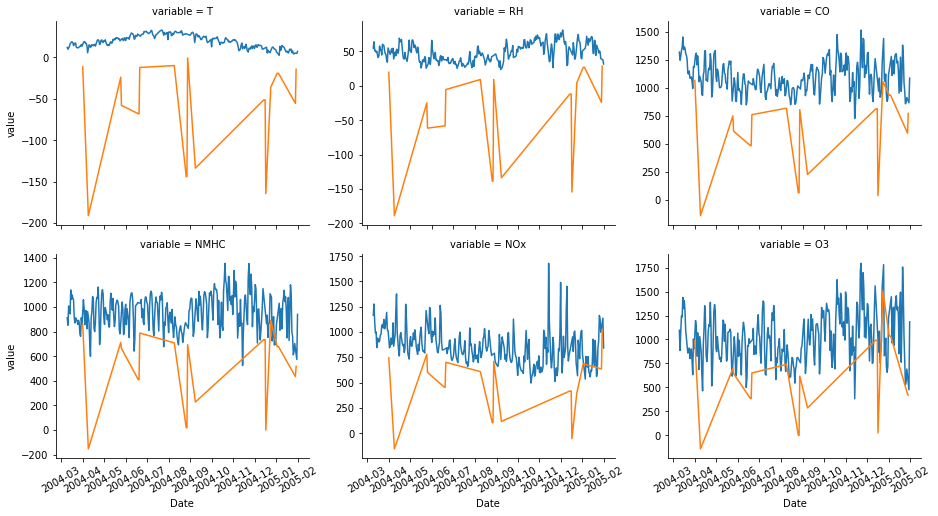

In [8]:
g = sns.FacetGrid(
        pd.melt(
            df_time_impute, 
            id_vars='Drift', 
            value_vars=['T', 'RH', 'CO', 'NMHC', 'NOx', 'O3'], 
            ignore_index=False).reset_index(), 
        col="variable", 
        hue = 'Drift',
        col_wrap= 3,
        sharey=False,
        height=3.5,
        aspect=1.25
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
plt.show()

*Observation:*
- The Drifted Values does not seems to overlap with the orignal data, indicating the **anomaly of sensor drifting**. 
- The Trend of Drifted values has similar trend across all gasses, revealing that **once the sensor start drifting, recordings for all gases will be affected**.
- The Drifting Event seems to **happens at random** without any clear indication or tailtale sign.

The observation above makes handling of Drifted Values cumbersome and sensors drifting is a field under research attention. For simplicity baseline sack, I will just **Front-fill the values for the drifted data**. 

In [9]:
df_time_impute.loc[df_time_impute['Drift']] = np.nan
df_time_impute = df_time_impute.fillna(method = 'ffill')
df_time_impute.drop(columns= 'Drift', inplace = True)
df_time_impute

,T,RH,CO,NMHC,NOx,O3
Date,,,,,,
2004-03-10,12.020833,54.883334,1316.500000,912.250000,1167.250000,1096.041667
2004-03-11,9.833333,64.069791,1244.062500,851.802083,1277.187500,885.031250
2004-03-12,11.292708,51.107292,1281.562500,1008.229167,1101.718750,1084.218750
2004-03-13,12.866319,51.530903,1330.555556,992.822917,993.159722,1245.781250
2004-03-14,16.016667,48.843750,1360.927083,943.854167,1001.104167,1234.177083
...,...,...,...,...,...,...
2005-01-27,5.267708,39.614930,911.777778,703.312500,997.059028,691.475694
2005-01-28,5.267708,39.614930,911.777778,703.312500,997.059028,691.475694
2005-01-29,5.267708,39.614930,911.777778,703.312500,997.059028,691.475694


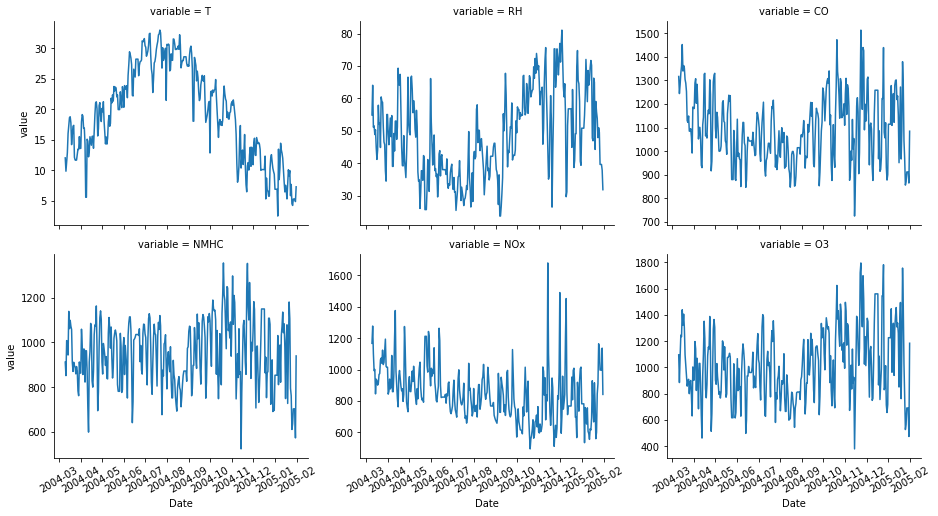

In [10]:
g = sns.FacetGrid(
        pd.melt(
            df_time_impute, 
            ignore_index=False).reset_index(), 
        col="variable",
        col_wrap= 3,
        sharey=False,
        height=3.5,
        aspect=1.25
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
plt.show()

I noticed that the **trend seems to be much more consistent** like a stationary random walk after removing the drifted data.

# Time-Series Analysis

## Dickey Fuller Test for Stationarity Series
To model a time-series using ARMA model, we need to ensure the time-series is stationary, that is the the **mean, variance and covariance does not vary with time.**

To verify stationarity, we will be utilising Augmented Dickey Test at Significant Value, $p=0.05$ with,
$$
H_0 : \text{Time-Series is Non-Stationary} \\
H_1 : \text{Time-Series is Stationary} 
$$

In [11]:
p_value = []
for var in df_time_impute.columns:
    p_value.append(adfuller(df_time_impute[var])[1]) # Run Adfuller test to determine is the time-series Stationary

pd.DataFrame(dict(Variable = df_time_impute.columns,P_Value = p_value, Stationary = [p<0.05 for p in p_value]))

,Variable,P_Value,Stationary
0,T,7.839651e-01,False
1,RH,5.004329e-04,True
2,CO,3.744836e-13,True
3,NMHC,4.124349e-03,True
4,NOx,1.459045e-03,True
5,O3,1.514280e-02,True


From the result generated, I have noticed that **except for `T`**, the **rest of gases are in stationary form** and hence, we don't need to apply any transformation towards the data. With that, I will continue with further analysis using Auto-Correlation & Partial Auto-Correlation Plot to gain some intuition for parameters of our model.

## Auto-Correlation & Partial Auto-Correlation Plot
After ensuring our time-series is stationary, ACF and PACF can be helpful for us to **get a sense on how previous values can be useful for us to predict the current value** for each different gasses. With that we can **interpret the $ p\,\&\,q $ value** for our ARMA or ARMAX model *(by identifying the lags where the coefficient is significantly different from 0)*

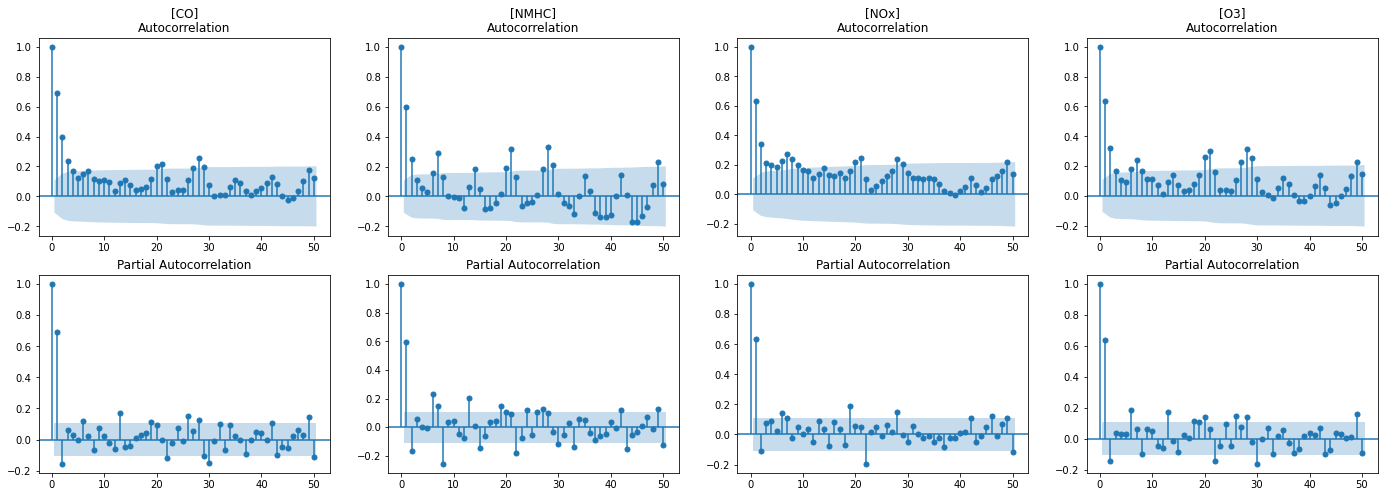

In [110]:
target_vars = ['CO', 'NMHC', 'NOx', 'O3']

fig, axes = plt.subplots(2,4, figsize = (24,8))
for idx, variable in enumerate(target_vars):
    plot_acf(df_time_impute[variable], lags = 50, ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df_time_impute[variable], lags = 50, ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation".format(variable))
plt.show()

**Observation Summary**

| Gasses | AR(p significant lags) | MA(q significant lags) | Remarks | Potential Initial Model |
| ---    | ---   | ---   | :---                                   | :---    |
| CO     | 2     | 3   | Weak Seasonal Trend every 13 Iteration| MA(3)/ AR(2)/ ARMA(2,3)/SARIMA(2,0,3)(1,0,1,13) |
| NMHC   | 2     | 2     | Weak Seasonal Trend every 7 Iteration | MA(2)/ AR(2)/ ARMA(2,2)/ SARIMA(1,0,2)(2,0,1,7)
| NOx    | 2     | 2     | -                                     | MA(2)/ AR(2)/ ARMA(2,2) |
| O3     | 2     | 3     | Weak Seasonal Trend every 7 Iteration | MA(3)/ AR(2)/ ARMA(2,3)/SARIMA(1,0,2)(1,0,1,7)


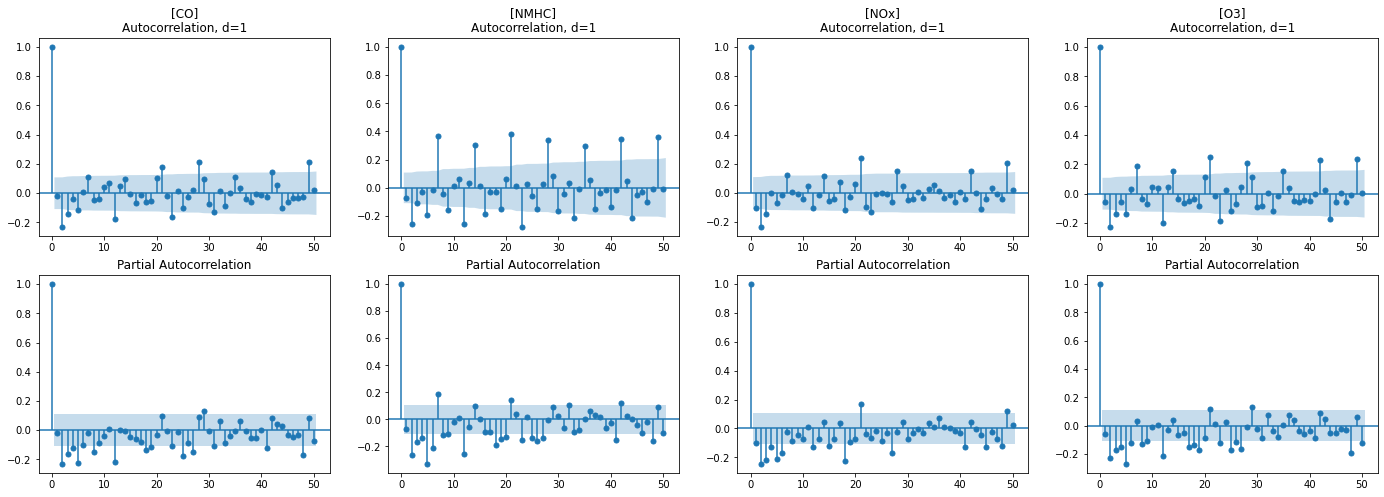

In [187]:
target_vars = ['CO', 'NMHC', 'NOx', 'O3']

fig, axes = plt.subplots(2,4, figsize = (24,8))
for idx, variable in enumerate(target_vars):
    plot_acf(df_time_impute[variable].diff().dropna(), lags = 50, ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df_time_impute[variable].diff().dropna(), lags = 50, ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation, d=1".format(variable))
plt.show()

**Observation Summary, d=1**

| Gasses | AR(p significant lags) | MA(q significant lags) | Remarks | Potential Initial Model |
| ---    | ---   | ---   | :---                                   | :---    |
| CO     | 5     | 3   | Weak Seasonal Trend every 28 Iteration| ARIMA(5,1,3)/SARIMA(5,1,3)(1,1,2,28) |
| NMHC   | 6     | 5     | Weak Seasonal Trend every 7 Iteration | ARIMA(6,1,5)/ SARIMA(6,1,5)(3,1,4,7)
| NOx    | 6     | 3     | Weak Seasonal Trend every 21 Iteration| ARIMA(6,1,3)/ SARIMA(6,1,5)(2,1,2,21) |
| O3     | 6     | 5     | Weak Seasonal Trend every 21 Iteration | ARIMA(6,1,5)/SARIMA(6,1,5)(1,1,2,21)


# Sampling Techniques : Expanding Window
An unbiased model evaluation technique is crucial for us to understand the general potential of the model. One way to achieve it is through **training and evaluating the model multiple time each with different window of dataset**.

This is where Expanding Window technique comes into play as illustrated below:

![Uber Engineering Expanding Window](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/01/image6-2-1024x542.png)

Original article: [https://eng.uber.com/omphalos/](https://eng.uber.com/omphalos/)

Since our test_set has size of 63, I will use that as our testing window size. I will also set the number of splits into 3 portion 

In [189]:
TEST_SIZE = 63
train_data = df_time_impute.iloc[:-TEST_SIZE]
test_data = df_time_impute.iloc[-TEST_SIZE:]

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def expanding_window(model, endog, exog=None, test_size=TEST_SIZE, n_splits=3, **kwargs):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    rmse_hist = []
    aic_hist = []
    for idx, (train_index, test_index) in enumerate(tscv.split(endog)):
        warnings.filterwarnings("ignore")
        if exog is not None:
            res = model(endog.iloc[train_index], exog.iloc[train_index], **kwargs).fit()
            yhat = res.forecast(test_size, exog = exog.iloc[test_index])
        else:
            res = model(endog.iloc[train_index], **kwargs).fit()
            yhat = res.forecast(test_size)
        ytrue = endog.iloc[test_index]
        rmse_hist.append(rmse(ytrue, yhat))
        aic_hist.append(res.aic)
    return np.array(rmse_hist).mean(), np.array(aic_hist).mean()

expanding_window(SARIMAX, train_data.CO)

(248.15594162532864, 1650.7224888195924)

# Univariate Time-Series Modelling

## Baseline Model : Average Forecast
With our sampling techniques set up, let us establish a baseline model to provide us another reference point to the performance of the model that we are building.

I will be using an [Average Forecast](https://otexts.com/fpp2/simple-methods.html#average-method) that **Predicts Current Observation based on the Mean** of the historical data. 

$$
\hat{y} = \frac{1}{T} \sum^T_{t=1} y_t
$$

The performance will be **Evaluated Using the Same Expanding Window** techniques as mentioned above.


In [119]:
def expanding_window_baseline(endog:pd.Series, test_size=TEST_SIZE, n_splits=3):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    # Array to Record all RMSE
    rmse_hist = []
    
    for iters, (train_index, test_index) in enumerate(tscv.split(endog)):     
        train = endog.iloc[train_index]
        test = endog.iloc[test_index]
        yhat = pd.Series(train.mean()).repeat(test_size)
        
        rmse_hist.append(rmse(test.values, yhat.values))

    return np.array(rmse_hist).mean()

base_hist = dict()
for var in target_vars:
    base_hist[var] = expanding_window_baseline(endog=train_data[var])
pd.DataFrame(base_hist, index = ['baseline_rmse']).T

,baseline_rmse
CO,153.366221
NMHC,146.519079
NOx,183.332560
O3,257.749547


## ARIMA Forecast : Interpreted Model
By using the interpreted value from the ACF and PCAF plot, let us build the initial ARMA model and evaluate the performance using the Expanding Window Technique. From the outputted result, I realise that the interpreted model is just **performing slightly better than the baseline** average forecast. Hence, I will explore ARIMA model further by Grid Searching the orders for my ARIMA model. 

In [194]:
orders = [(2,0,3),(2,0,2),(2,0,5),(2,0,3),(5,1,3),(6,1,5),(6,1,3),(6,1,5)]
hist = dict()
for idx, order in enumerate(orders):
    hist[f'{target_vars[idx%4]} {order}'] = expanding_window(ARIMA, train_data[target_vars[idx%4]], order = order)
pd.DataFrame(hist).T.rename(columns = {0:"RMSE", 1:"AIC"}).head(10)

,RMSE,AIC
"CO (2, 0, 3)",150.163563,1622.959167
"NMHC (2, 0, 2)",145.953269,1661.373538
"NOx (2, 0, 5)",172.189272,1689.601666
"O3 (2, 0, 3)",253.258412,1805.618220
"CO (5, 1, 3)",130.520877,1609.662279
"NMHC (6, 1, 5)",140.630756,1627.391221
"NOx (6, 1, 3)",153.317551,1673.488005
"O3 (6, 1, 5)",248.079196,1799.304067


## ARIMA Forecast : Hyperparameter Tuning

I will be using ARIMA model as the univariate model for the initial time series forecasting. Since each of the 4 different gasses have different trend and distribution, I will be **fitting different model for each of the gasses** and perform **hyperparameter tuning independently**, using the **Expanding Window technique**. I will be minimizing the **Aikeike Information Criteria(AIC) in addition with the Root Mean Squared Error(RMSE)** to evaluate the performance and simpleness of the model.

### CO

In [57]:
cv_result_CO = dict()
for p in tqdm(range(10)):
    for q in range(10):
        for l in range(2):
            rmse_no, aic = expanding_window(ARIMA, train_data.CO, order=(p,l,q))
            cv_result_CO['({},{},{})'.format(p,l,q)] = [rmse_no, aic]
pd.DataFrame(cv_result_CO).T.rename(columns = {0:"RMSE", 1:"AIC"}).sort_values(["AIC", "RMSE"]).head(10)

,RMSE,AIC
"(3,1,4)",130.167628,1603.053095
"(2,1,5)",131.342978,1603.294595
"(4,1,4)",127.591969,1604.683450
"(2,1,1)",131.662047,1605.001684
"(2,1,6)",132.240756,1605.011813
"(2,1,4)",132.595702,1606.578172
"(2,1,2)",131.281747,1606.733364
"(4,1,5)",129.927603,1606.875692
"(3,1,1)",131.294488,1606.890484
"(1,1,2)",133.265819,1606.990946


### NMHC

In [58]:
cv_result_NMHC = dict()
for p in tqdm(range(10)):
    for q in range(10):
        for l in range(2):
            rmse_no, aic = expanding_window(ARIMA, train_data.NMHC, order=(p,l,q))
            cv_result_NMHC['({},{},{})'.format(p,l,q)] = [rmse_no, aic]
pd.DataFrame(cv_result_NMHC).T.rename(columns = {0:"RMSE", 1:"AIC"}).sort_values(["AIC","RMSE"]).head(10)

,RMSE,AIC
"(6,1,6)",134.313186,1621.743978
"(7,1,7)",131.420575,1621.865820
"(9,1,7)",130.462791,1622.542622
"(7,1,8)",134.251700,1622.673064
"(5,1,8)",130.477650,1623.034805
"(4,1,8)",133.043999,1623.092467
"(7,1,6)",134.770474,1623.303937
"(7,1,9)",133.877737,1623.308584
"(5,1,9)",131.149732,1623.319477
"(6,1,9)",131.245784,1623.483871


### NOx

In [59]:
l = 0
cv_result_NOx = dict()
for p in tqdm(range(10)):
    for q in range(10):
        for l in range(2):
            try:
                rmse_no, aic = expanding_window(ARIMA, train_data.NOx, order=(p,l,q))
                cv_result_NOx['({},{},{})'.format(p,l,q)] = [rmse_no, aic]
            except:
                continue
pd.DataFrame(cv_result_NOx).T.rename(columns = {0:"RMSE", 1:"AIC"}).sort_values(["AIC","RMSE"]).head(10)

,RMSE,AIC
"(7,1,7)",164.757029,1662.602059
"(8,1,8)",146.977765,1664.471816
"(9,1,7)",162.069575,1664.862586
"(7,1,8)",149.138733,1666.583146
"(6,1,8)",153.002665,1666.768249
"(2,1,4)",152.528331,1667.068546
"(9,1,8)",162.591421,1667.675075
"(5,1,8)",148.239545,1668.094889
"(3,1,4)",148.489783,1668.192907
"(2,1,5)",155.518306,1668.755657


### O3

In [60]:
l = 0
cv_result_O3 = dict()
for p in tqdm(range(10)):
    for q in range(10):
        for l in range(2):
            try:
                rmse_no, aic = expanding_window(ARIMA, train_data.O3, order=(p,l,q))
                cv_result_O3['({},{},{})'.format(p,l,q)] = [rmse_no, aic]
            except:
                continue
pd.DataFrame(cv_result_O3).T.rename(columns = {0:"RMSE", 1:"AIC"}).sort_values(["AIC", "RMSE"]).head(10)

,RMSE,AIC
"(5,1,4)",647451.972226,1204.985477
"(7,1,8)",252.274721,1794.328286
"(3,1,4)",248.810708,1795.259574
"(2,1,4)",245.104066,1795.309806
"(7,1,7)",242.780002,1795.741758
"(8,1,7)",253.200024,1796.587698
"(2,1,6)",241.259058,1797.078335
"(4,1,8)",252.569546,1797.494304
"(4,1,4)",240.403244,1797.772062
"(5,1,6)",249.155905,1797.982445


**ARIMA Observation Summary**

| Gasses | AR(p significant lags) |I(d integrate lags) | MA(q significant lags) | RMSE       | AIC | Baseline   |
| ---    | ---                    | ---                |:--                     | :---       | :--- |:---      |
| CO     | 3                      | 1                  | 4                      | 130.167628 |	1603.053095 |153.366220 |
| NMHC   | 6                      | 1                  | 6                      | 	134.313186	| 1621.743978| 146.519079 |
| NOx    | 8                      | 1                  | 8                      | 146.977765 | 	1664.471816| 183.332560|
| O3     | 7                      | 1                  | 7                      | 242.780002 | 1795.741758| 257.749546 |

Based on the cross-validated result, it seems that ARIMA is able to **Perform better than the Average baseline**. Let us visualise the prediction by plotting it out.


### ARIMA Forecast : Visualising the Forecast 
Most of the time, number alone doesnt tell the whole story and it is always a good idea to visualise the forecast to get a basic idea on how can we improve the forecast. For that, I will be **using the last 63 observation as the test set to visualise the forecast**.

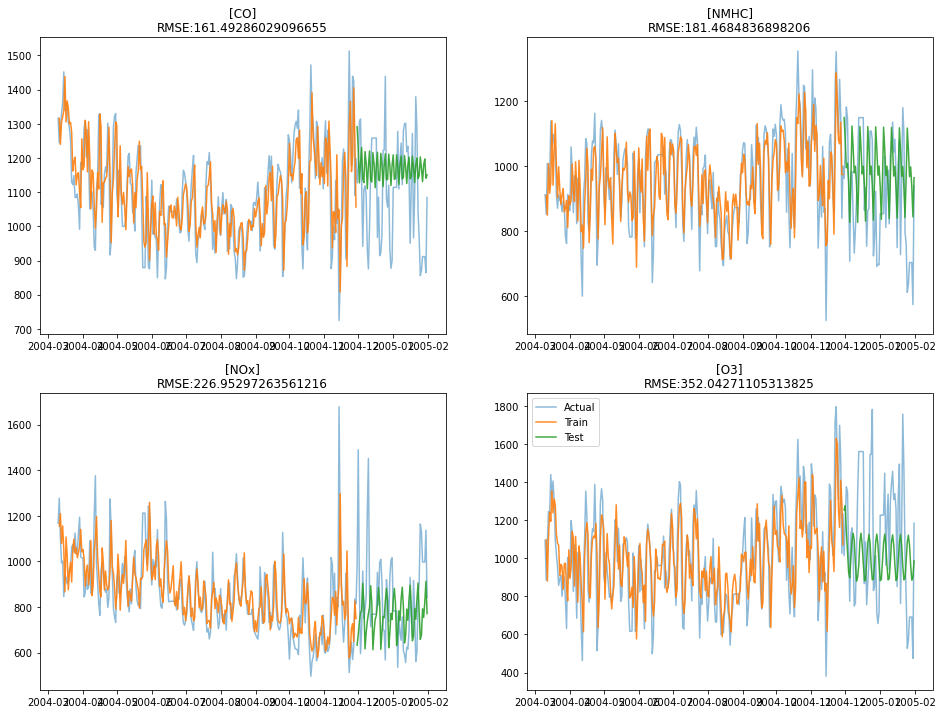

In [121]:
orders = [(3,1,4),(8,1,9),(8,1,8),(7,1,7)]

fig, axes = plt.subplots(2,2, figsize=(16, 12))

for idx, order in enumerate(orders):
    mod = ARIMA(train_data[target_vars[idx]], order = order)
    res = mod.fit()

    full_pred = res.predict()
    pred = res.forecast(TEST_SIZE)

    axes[idx//2, idx%2].set_title("[{}]\nRMSE:{}".format(
        target_vars[idx], rmse(test_data[target_vars[idx]],pred)))
    axes[idx//2, idx%2].plot(df_time_impute[target_vars[idx]], label = 'Actual', alpha=0.5)
    axes[idx//2, idx%2].plot(full_pred.iloc[1:], label = 'Train', alpha=0.9)
    axes[idx//2, idx%2].plot(pred, label='Test', alpha=0.9)
plt.legend()
plt.show()

By visualising the test set, I realise that the Univariate ARIMA Model is just **oscillating with a specific trend** around the average. Besides, I also realised that ARIMA Model works fine for NMHC and NOx however it seems to be underperforming for CO and O3.


# Multivariate Time Series : ARIMAX
Based on the observation from the Univariate model, I realise that the prediction is not robust enough. Hence, let us take a step further by exploring the ARIMAX model (i.e. ARIMA with **additional Exogenous Variable**) for Multivariate time-series forecasting instead.

## Correlation Matrix
Since the final predicted value will be a linear combination of previous datapoints as well as with the additional Exogenous Variable, let us **Investigate the Linear Relationship** between the variables before building the model to corroborate the notion of building a Multivariate Model.

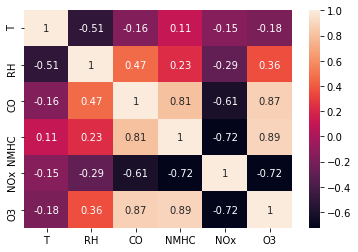

In [17]:
sns.heatmap(df_time_impute.corr(), annot=True)
plt.show()

It seems that the Exogenous Variable (i.e. T, RH) has **moderate linear relationship** with our target variables (i.e. CO, NMHC, NOx, O3). Hence, let us proceed with the building of ARIMAX model.

## ARIMAX Forecast : Hyperparameter Tuning

CO

In [123]:
l = 0
cv_result_X_CO = dict()
for p in tqdm(range(10)):
    for q in range(10):
        for l in range(2):
            rmse_no, aic = expanding_window(ARIMA,train_data.CO, exog = train_data[['T','RH']], order=(p,l,q))
            cv_result_X_CO['({},{},{})'.format(p,l,q)] = [rmse_no, aic]
pd.DataFrame(cv_result_X_CO).T.rename(columns = {0:"RMSE", 1:"AIC"}).sort_values(["AIC","RMSE"]).head(10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:43<00:00, 34.37s/it]


,RMSE,AIC
"(2,1,4)",169.775843,1571.226480
"(3,1,4)",171.124384,1571.542368
"(4,1,4)",167.683819,1574.917414
"(2,1,6)",167.397615,1575.265133
"(4,1,2)",175.825776,1575.452237
"(4,1,3)",169.753739,1575.577804
"(3,1,5)",156.192118,1575.579060
"(5,1,6)",157.115036,1576.444995
"(3,1,6)",159.655798,1576.818094
"(6,1,0)",168.979531,1577.055289


NMHC

In [72]:
l = 0
cv_result_X_NMHC = dict()
for p in tqdm(range(10)):
    for q in range(10):
        for l in range(2):
            try:
                rmse_no, aic = expanding_window(ARIMA,train_data.NMHC, exog = train_data[['T','RH']], order=(p,l,q))
                cv_result_X_NMHC['({},{},{})'.format(p,l,q)] = [rmse_no, aic]
            except:
                continue
pd.DataFrame(cv_result_X_NMHC).T.rename(columns = {0:"RMSE", 1:"AIC"}).sort_values(["AIC", "RMSE"]).head(10)

,RMSE,AIC
"(9,1,5)",379.960183,1328.899090
"(5,1,8)",142.601644,1602.235755
"(5,1,9)",147.237923,1602.903690
"(6,1,9)",143.155550,1603.113815
"(4,1,9)",136.384734,1603.501110
"(7,1,7)",145.888713,1604.190350
"(6,1,6)",145.272368,1604.285831
"(5,1,6)",143.796941,1604.742768
"(4,1,8)",141.630289,1604.770386
"(5,1,7)",143.191099,1605.567496


NOx

In [73]:
l = 0
cv_result_X_NOx = dict()
for p in tqdm(range(10)):
    for q in range(10):
        for l in range(2):
            try:
                rmse_no, aic = expanding_window(ARIMA,train_data.NOx, exog = train_data[['T','RH']], order=(p,l,q))
                cv_result_X_NOx['({},{},{})'.format(p,l,q)] = [rmse_no, aic]
            except:
                continue
pd.DataFrame(cv_result_X_NOx).T.rename(columns = {0:"RMSE", 1:"AIC"}).sort_values(["AIC", "RMSE"]).head(10)

,RMSE,AIC
"(7,1,7)",155.411699,1649.813866
"(3,1,4)",163.741213,1650.049998
"(2,1,4)",147.793920,1650.419511
"(7,1,8)",158.129388,1650.769569
"(2,1,5)",154.772236,1650.784711
"(4,1,4)",155.337661,1652.698497
"(8,1,8)",158.308190,1653.154739
"(4,1,3)",163.637994,1653.476297
"(8,1,7)",158.008597,1653.636198
"(7,1,4)",169.124835,1653.710424


O3

In [74]:
l = 0
cv_result_X_O3 = dict()
for p in tqdm(range(10)):
    for q in range(10):
        for l in range(2):
            try:
                rmse_no, aic = expanding_window(ARIMA,train_data.O3, exog = train_data[['T','RH']], order=(p,l,q))
                cv_result_X_O3['({},{},{})'.format(p,l,q)] = [rmse_no, aic]
            except:
                continue
pd.DataFrame(cv_result_X_O3).T.rename(columns = {0:"RMSE", 1:"AIC"}).sort_values(["AIC", "RMSE"]).head(10)

,RMSE,AIC
"(2,1,4)",281.052771,1777.169993
"(3,1,4)",273.621021,1779.018209
"(6,1,0)",280.742239,1779.068894
"(5,1,1)",280.115937,1779.854510
"(4,1,3)",276.487583,1780.054896
"(4,1,2)",280.919512,1780.626669
"(4,1,6)",265.951672,1780.745181
"(4,1,4)",273.638488,1780.946186
"(7,1,0)",279.340527,1781.041825
"(6,1,1)",279.254345,1781.104608


**ARIMAX Observation Summary**

| Gasses | AR(p significant lags) |I(d integrate lags) | MA(q significant lags) | RMSE       | AIC | 
| ---    | ---                    | ---                |:--                     | :---       | :--- |
| CO     | 2                      | 1                  | 4                      | 169.775843 |	1571.226480 |
| NMHC   | 5                      | 1                  | 8                      | 142.601644 |	1602.235755 |
| NOx    | 7                      | 1                  | 7                      | 155.411699 |	1649.813866 |
| O3     | 7                      | 0                  | 8                      | 	265.609792	|1814.826820 |


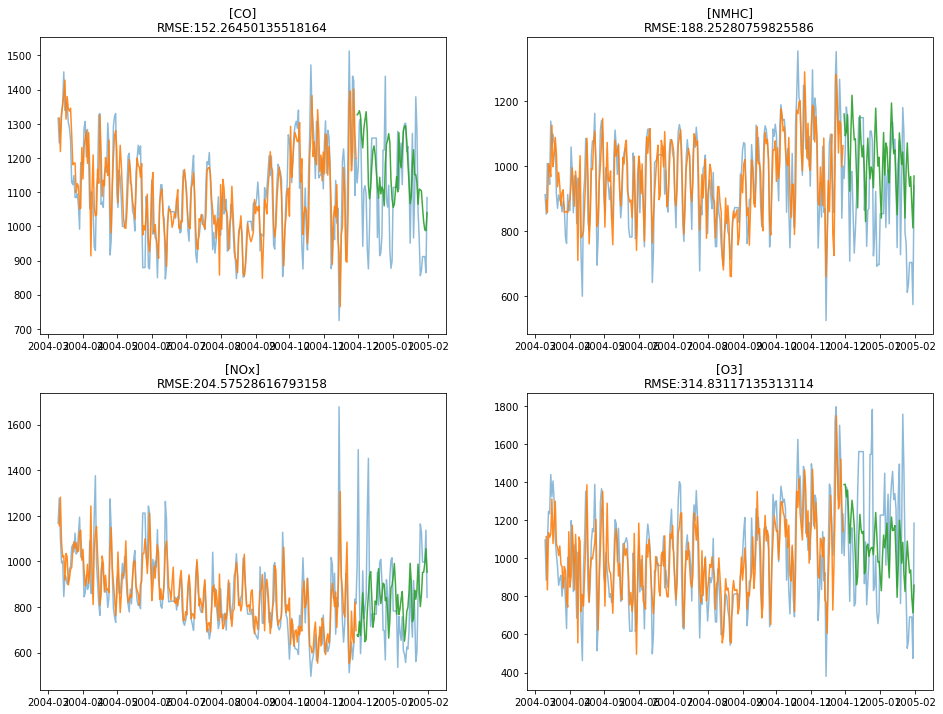

In [241]:
train = df_time_impute[target_vars].iloc[:-63]
train_x = df_time_impute[[col for col in df_time_impute.columns if col not in target_vars]].iloc[:-63]
test = df_time_impute[target_vars].iloc[-63:]
test_x = df_time_impute[[col for col in df_time_impute.columns if col not in target_vars]].iloc[-63:]
orders = [(2,1,4), (5,1,8), (7,1,7), (7,0,9)]

fig, axes = plt.subplots(2,2, figsize=(16, 12))
result = {}

for idx, order in enumerate(orders):
    mod = ARIMA(train.iloc[:,idx], exog=train_x, order = order)
    res = mod.fit()
    
    result[target_vars[idx]] = res.summary()

    full_pred = res.predict()
    pred = res.forecast(test.shape[0], exog=test_x)

    axes[idx//2, idx%2].set_title("[{}]\nRMSE:{}".format(
        target_vars[idx], mean_squared_error(test[target_vars[idx]],pred,squared=False)))
    axes[idx//2, idx%2].plot(df_time_impute[target_vars[idx]], alpha=0.5)
    axes[idx//2, idx%2].plot(full_pred.iloc[1:], alpha=0.9)
    axes[idx//2, idx%2].plot(pred, alpha=0.9)
plt.show()

In [243]:
for var, summary in result.items():
    print(f"{var}\n{summary}\n")

CO
                               SARIMAX Results                                
Dep. Variable:                     CO   No. Observations:                  265
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1524.002
Date:                Wed, 11 Aug 2021   AIC                           3066.004
Time:                        12:27:08   BIC                           3098.187
Sample:                    03-10-2004   HQIC                          3078.936
                         - 11-29-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             16.0404      1.788      8.971      0.000      12.536      19.545
RH             3.9266      0.753      5.216      0.000       2.451       5.402
ar.L1          1.2383      0.016     78.098      

From the cross-validated result as well as through the final test result, I have noticed that ARIMAX is much **better at capturing the general trend of movement** for the data than ARIMA model. Finallly, let us explore the notion of seasonality since its effect is observed in the PACF and ACF plot as well as in the ARIMAX orders.

# Multivariate Time Series : Seasonal ARIMA

## Seasonal Decomposition
By choosing the seasonal period of 7, I've noticed that the time series can be decomposed nicely into Trend, Seasonality and Residuals. Besides, the residual also appear to be randomly scattered which indicates that the decomposition is valid.

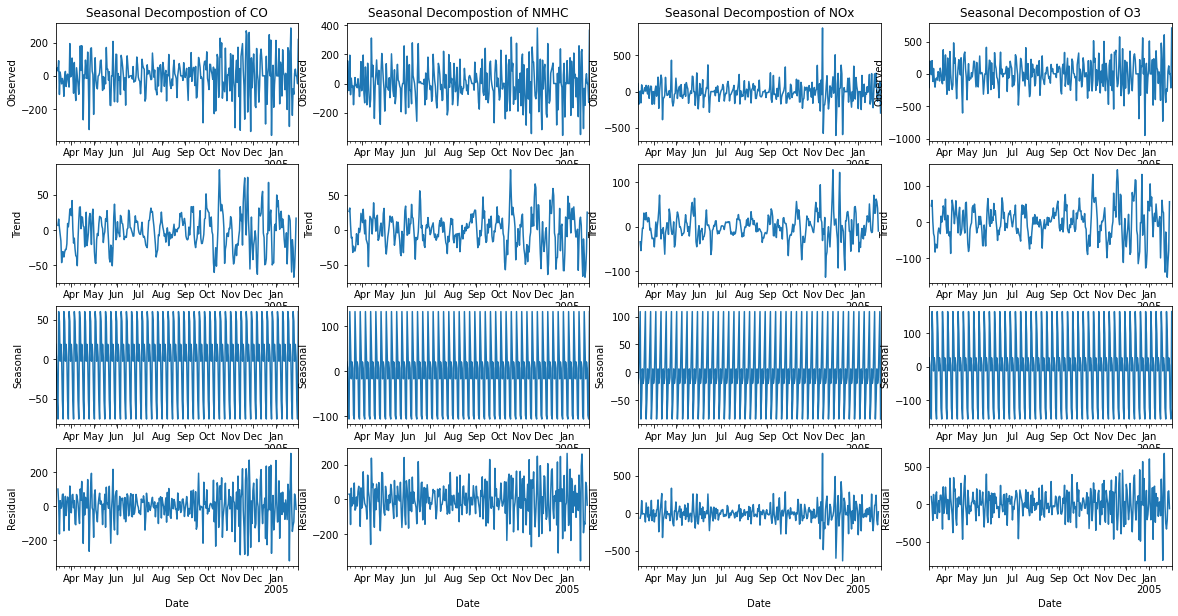

In [248]:
def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    
fig, axes = plt.subplots(4,4, figsize = (20,10))
seasonal_hist = dict()
for idx, var in enumerate(target_vars):
    axes[0,idx].set_title("Seasonal Decompostion of {}".format(var))
    result = seasonal_decompose(df_time_impute[var].diff().dropna(), model='additive', period=7)
    seasonal_hist[var] = result.seasonal
    plotseasonal(result, axes[:,idx])
plt.show()

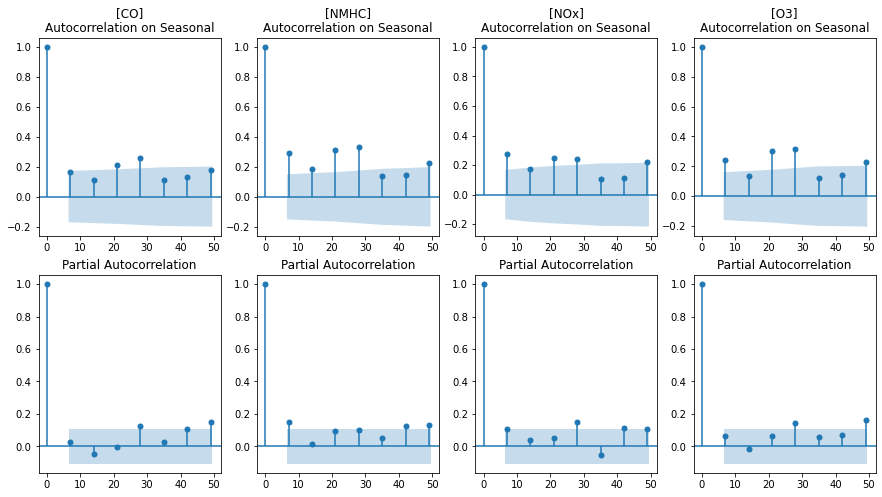

In [143]:
target_vars = ['CO', 'NMHC', 'NOx', 'O3']

fig, axes = plt.subplots(2,4, figsize = (15,8))
for idx, variable in enumerate(target_vars):
    plot_acf(df_time_impute[variable], lags = range(0,50,7), ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df_time_impute[variable], lags = range(0,50,7), ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation on Seasonal".format(variable))
plt.show()

By analysing the ACF and PACF of seasonal trend of 7, I can interpret the P and Q order for the Seasonal Component of ARIMA as documented below:

**Observation Summary**

| Gasses | AR(P significant lags) | MA(Q significant lags) | 
| ---    | ---   | ---   |
| CO     | 0     | 0     |  
| NMHC   | 1     | 4     |
| NOx    | 1     | 4     |
| O3     | 0     | 4     |


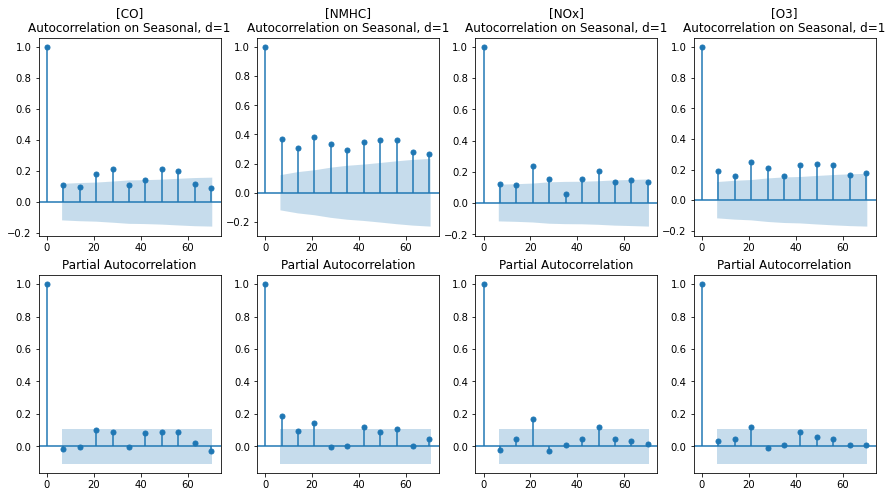

In [186]:
target_vars = ['CO', 'NMHC', 'NOx', 'O3']

fig, axes = plt.subplots(2,4, figsize = (15,8))
for idx, variable in enumerate(target_vars):
    plot_acf(df_time_impute[variable].diff().dropna(), lags = range(0,75,7), ax = axes[0, idx]) # Looks for MA(q)
    plot_pacf(df_time_impute[variable].diff().dropna(), lags = range(0,75,7), ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation on Seasonal, d=1".format(variable))
plt.show()

## SARIMAX Forecast : Interpreted Model
Based on the PACF and ACF plot, we have interpreted a few potential orders for the seasonal ARIMA and let us explore it further by getting the cross-validated score.

In [203]:
sarima_hist_back1 = sarima_hist_back.copy() 
sarima_order = [None, 
                ((2,0,2),(1,0,4,7)),
                ((2,0,5),(1,0,4,7)), 
                ((2,0,3),(0,0,4,7)),
                ((5,1,3),(1,1,2,28)),
                ((6,1,5),(3,1,4,7)),
                ((6,1,5),(2,1,2,21)),
                ((6,1,5),(1,1,2,21))]
sarima_hist = dict()

for idx, orders in enumerate(sarima_order):
    if orders is None:
        continue
    else:
        (p,d,q),(P,D,Q,m) = orders
        rmse_aic_tuple = expanding_window(SARIMAX, train_data[target_vars[idx%4]], exog = train_x, order = (p,d,q), seasonal_order=(P,D,Q,m))
pd.DataFrame(sarima_hist, index = ['RMSE','AIC']).T

,RMSE,AIC
"NMHC : (2,0,2),(1,0,4,7)",173.150673,1625.627387
"NOx : (2,0,5),(1,0,4,7)",235.109636,1709.281055
"O3 : (2,0,3),(0,0,4,7)",351.066904,1813.067125
"CO : (5,1,3),(1,1,2,28)",186.473693,1292.835844
"NMHC : (6,1,5),(3,1,4,7)",134.082659,1546.460306
"NOx : (6,1,5),(2,1,2,21)",135.550182,1436.865677
"O3 : (6,1,5),(1,1,2,21)",239.958456,1542.921261


## SARIMAX Forecast : Hyperparameter Tuning

CO

In [200]:
cv_hist_co_sarimax = dict()
var = 'CO'

# Define Params Space
p_range = range(1,5)
d_range = [1]
q_range = range(1,5)
P_range = range(1,4)
D_range = [1]
Q_range = range(1,4)
m = [7,21,28]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_aic_tuple = expanding_window(SARIMAX, train_data[var], exog = train_x, order = (p,d,q), seasonal_order=(P,D,Q,m))
        cv_hist_co_sarimax[f'({p},1,{q}),({P},{D},{Q},{m})'] = rmse_aic_tuple
    except:
        continue

pd.DataFrame(cv_hist_co_sarimax, index=['rmse', 'aic']).T.sort_values(['rmse','aic']).head(10)

,rmse,aic
"(4,1,1),(1,1,3,21)",125.195855,1358.510975
"(3,1,3),(2,1,3,21)",129.822031,1364.126723
"(4,1,1),(2,1,2,21)",135.738389,1359.196422
"(4,1,1),(2,1,3,21)",136.001131,1362.163147
"(3,1,3),(1,1,3,21)",136.294928,1360.544722
"(4,1,3),(1,1,2,21)",136.622763,1361.982419
"(4,1,3),(1,1,3,21)",137.027623,1362.740175
"(3,1,3),(2,1,2,21)",137.033801,1360.100125
"(4,1,1),(2,1,1,21)",137.519005,1356.600623
"(3,1,4),(3,1,3,21)",139.429508,1367.132497


NMHC

In [208]:
cv_hist_NMHC_sarimax = dict()
var = 'NMHC'

# Define Params Space
p_range = range(1,5)
d_range = [1]
q_range = range(1,5)
P_range = range(1,4)
D_range = [1]
Q_range = range(1,4)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_aic_tuple = expanding_window(SARIMAX, train_data[var], exog = train_x, order = (p,d,q), seasonal_order=(P,D,Q,m))
        cv_hist_NMHC_sarimax[f'({p},1,{q}),({P},{D},{Q},{m})'] = rmse_aic_tuple
    except:
        continue
pd.DataFrame(cv_hist_NMHC_sarimax,  index=['rmse', 'aic']).T.sort_values(['rmse','aic']).head(10)

,rmse,aic
"(4,1,3),(3,1,1,7)",125.161663,1525.092355
"(4,1,4),(3,1,1,7)",126.711509,1534.595161
"(4,1,3),(3,1,2,7)",128.226330,1526.382491
"(4,1,2),(1,1,1,7)",128.915532,1519.366730
"(4,1,3),(2,1,2,7)",130.304067,1524.100829
"(4,1,2),(3,1,2,7)",130.513848,1525.773069
"(4,1,1),(2,1,2,7)",130.874510,1522.596203
"(3,1,3),(1,1,3,7)",131.124010,1527.773426
"(4,1,2),(1,1,3,7)",131.434745,1524.624137
"(4,1,4),(2,1,2,7)",131.747464,1528.833663


NOx

In [214]:
cv_hist_NOx_sarimax = dict()
var = 'NOx'

# Define Params Space
p_range = range(1,5)
d_range = [1]
q_range = range(1,5)
P_range = range(1,4)
D_range = [1]
Q_range = range(1,4)
m = [7,21]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_aic_tuple = expanding_window(SARIMAX, train_data[var], exog = train_x, order = (p,d,q), seasonal_order=(P,D,Q,m))
        cv_hist_NOx_sarimax[f'({p},1,{q}),({P},{D},{Q},{m})'] = rmse_aic_tuple
    except:
        continue

pd.DataFrame(cv_hist_NOx_sarimax, index=['rmse', 'aic']).T.sort_values(['rmse','aic']).head(10)

,rmse,aic
"(2,1,4),(1,1,2,21)",130.787961,1427.906009
"(2,1,4),(3,1,2,21)",132.450259,1432.513321
"(2,1,4),(1,1,3,21)",132.823335,1427.832491
"(2,1,4),(2,1,2,21)",132.960372,1427.011309
"(2,1,4),(3,1,1,21)",133.367903,1426.213765
"(2,1,4),(1,1,1,21)",133.409291,1425.022965
"(2,1,4),(2,1,3,21)",133.975756,1429.966756
"(2,1,4),(3,1,3,21)",134.210009,1434.742365
"(2,1,4),(2,1,1,21)",135.243593,1427.770062
"(3,1,1),(2,1,3,21)",136.421053,1424.587954


O3

In [216]:
cv_hist_O3_sarimax = dict()
var = 'O3'

# Define Params Space
p_range = range(1,5)
d_range = [1]
q_range = range(1,5)
P_range = range(1,4)
D_range = [1]
Q_range = range(1,4)
m = [7,21]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_aic_tuple = expanding_window(SARIMAX, train_data[var], exog = train_x, order = (p,d,q), seasonal_order=(P,D,Q,m))
        cv_hist_O3_sarimax[f'({p},1,{q}),({P},{D},{Q},{m})'] = rmse_aic_tuple
    except:
        continue

pd.DataFrame(cv_hist_O3_sarimax, index=['rmse', 'aic']).T.sort_values(['rmse','aic']).head(10)

,rmse,aic
"(4,1,4),(1,1,1,21)",234.168264,1536.897802
"(3,1,2),(3,1,1,7)",236.635236,1706.956831
"(3,1,3),(3,1,3,21)",236.691621,1540.025119
"(3,1,4),(3,1,3,21)",240.491848,1537.823140
"(4,1,4),(2,1,1,21)",241.121738,1539.301608
"(4,1,4),(1,1,2,21)",241.335440,1538.682800
"(4,1,4),(3,1,1,21)",241.600028,1540.253450
"(3,1,2),(2,1,2,7)",242.083622,1701.907419
"(3,1,4),(3,1,2,21)",243.349287,1537.676249
"(4,1,4),(2,1,3,21)",243.839367,1543.029258


**SARIMAX Observation Summary**

| Gasses | ARIMA Order |Seasonal Order |   RMSE       | AIC | 
| ---    | ---                    | ---                | :---       | :--- |
| CO     | (4,1,1)                      | (1,1,3,21)                  | 125.195855 | 1358.510975 |
| NMHC   | (4,1,3)                      | (3,1,1,7)                   | 125.161663 | 1525.092355 |
| NOx    | (2,1,4)                      | (1,1,2,21)                  | 130.787961 | 1427.906009 |
| O3     | (4,1,4)                      | (1,1,1,21)                  | 234.168264 | 1536.897802 |


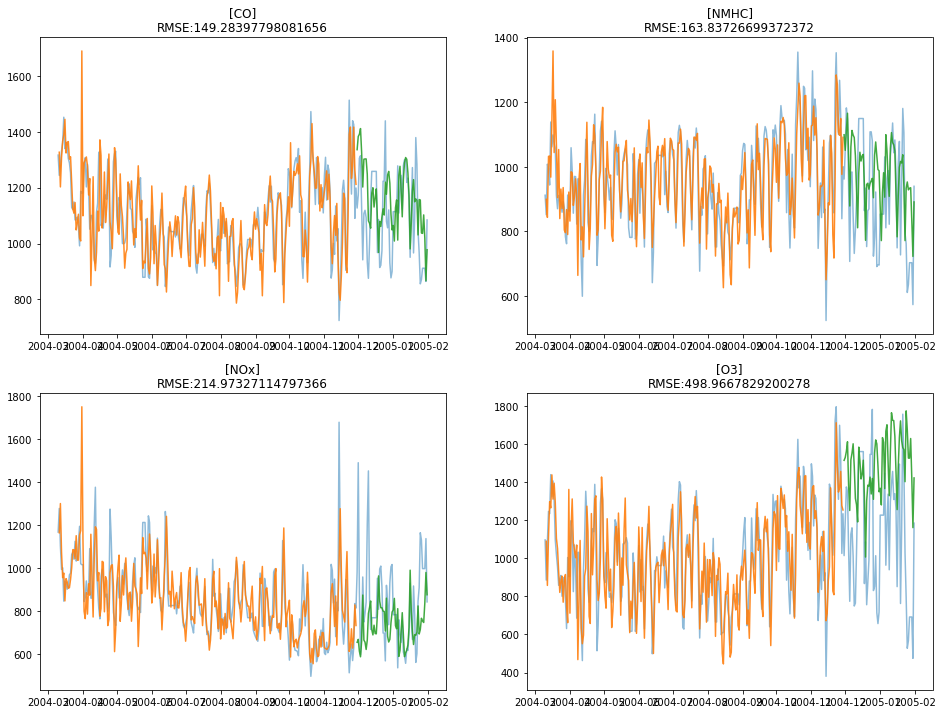

In [253]:
train = df_time_impute[target_vars].iloc[:-63]
train_x = df_time_impute[[col for col in df_time_impute.columns if col not in target_vars]].iloc[:-63]
test = df_time_impute[target_vars].iloc[-63:]
test_x = df_time_impute[[col for col in df_time_impute.columns if col not in target_vars]].iloc[-63:]
orders = [((4,1,1),(1,1,3,21)), ((4,1,3),(3,1,1,7)), ((2,1,4),(1,1,2,21)), ((4,1,4),(1,1,1,21))]
result_sarimax = {}

fig, axes = plt.subplots(2,2, figsize=(16, 12))

for idx, (order, seasonal_order) in enumerate(orders):
    mod = SARIMAX(train.iloc[:,idx], exog=train_x, order = order, seasonal_order = seasonal_order)
    res = mod.fit()
    result_sarimax[target_vars[idx]] = res

    full_pred = res.predict()
    pred = res.forecast(test.shape[0], exog=test_x)

    axes[idx//2, idx%2].set_title("[{}]\nRMSE:{}".format(
        target_vars[idx], mean_squared_error(test[target_vars[idx]],pred,squared=False)))
    axes[idx//2, idx%2].plot(df_time_impute[target_vars[idx]], alpha=0.5)
    axes[idx//2, idx%2].plot(full_pred.iloc[1:], alpha=0.9)
    axes[idx//2, idx%2].plot(pred, alpha=0.9)
plt.show()

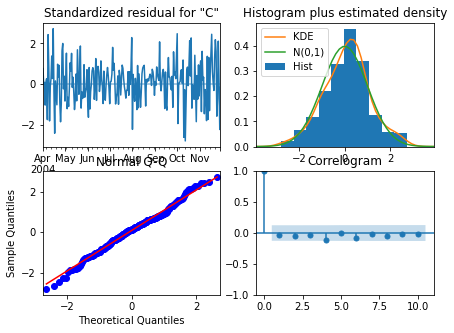

CO
                                         SARIMAX Results                                          
Dep. Variable:                                         CO   No. Observations:                  265
Model:             SARIMAX(4, 1, 1)x(1, 1, [1, 2, 3], 21)   Log Likelihood               -1410.726
Date:                                    Wed, 11 Aug 2021   AIC                           2845.452
Time:                                            16:47:14   BIC                           2887.369
Sample:                                        03-10-2004   HQIC                          2862.336
                                             - 11-29-2004                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             15.3956      1.461     10.540    

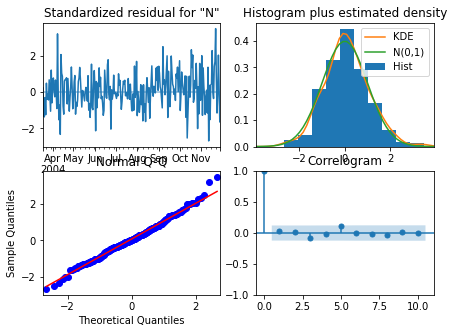

NMHC
                                      SARIMAX Results                                      
Dep. Variable:                                NMHC   No. Observations:                  265
Model:             SARIMAX(4, 1, 3)x(3, 1, [1], 7)   Log Likelihood               -1507.749
Date:                             Wed, 11 Aug 2021   AIC                           3043.498
Time:                                     16:47:15   BIC                           3093.185
Sample:                                 03-10-2004   HQIC                          3063.479
                                      - 11-29-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             15.0143      1.829      8.211      0.000      11.430      18.598
RH             2.2957 

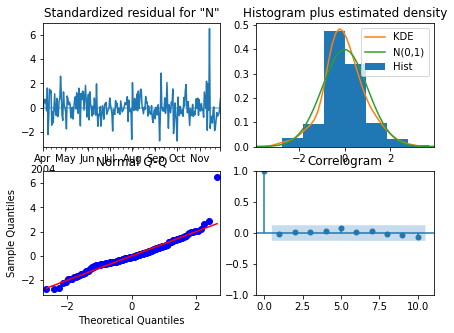

NOx
                                        SARIMAX Results                                        
Dep. Variable:                                     NOx   No. Observations:                  265
Model:             SARIMAX(2, 1, 4)x(1, 1, [1, 2], 21)   Log Likelihood               -1479.431
Date:                                 Wed, 11 Aug 2021   AIC                           2982.862
Time:                                         16:47:16   BIC                           3024.778
Sample:                                     03-10-2004   HQIC                          2999.745
                                          - 11-29-2004                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T            -15.3898      1.812     -8.494      0.000     -18.941    

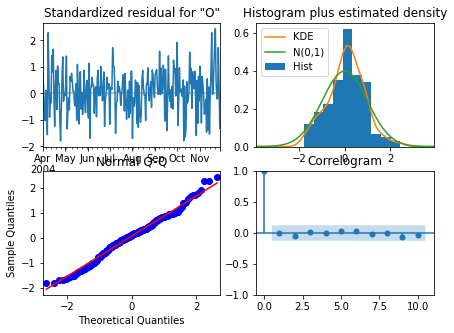

O3
                                      SARIMAX Results                                       
Dep. Variable:                                   O3   No. Observations:                  265
Model:             SARIMAX(4, 1, 4)x(1, 1, [1], 21)   Log Likelihood               -1585.833
Date:                              Wed, 11 Aug 2021   AIC                           3197.666
Time:                                      16:47:17   BIC                           3243.076
Sample:                                  03-10-2004   HQIC                          3215.957
                                       - 11-29-2004                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             20.2278      4.625      4.374      0.000      11.163      29.293
RH             4

In [256]:
for var, res in result_sarimax.items():
    res.plot_diagnostics(figsize=(7,5))
    plt.show()
    print(f"{var}\n{res.summary()}\n")

From the SARIMAX observation, it seems that all SARIMAX model is able to perform better than pure ARIMAX except for O3 gas. Hence for the final submission, I will be using SARIMAX for all 3 other gases but ARIMAX with O3.

# Kaggle Test Set Prediction

After we are satisfied with the model performance on the train and validation set, it is about time for us to generate the final prediction for the test set and submit it on the [Kaggle competition page](https://www.kaggle.com/c/st1511-aiml-timeseries/overview).

## Load Test Dataset
Let us load the test dataset and run some simple EDA to identify the Drifting Event.

In [218]:
test_df = pd.read_csv("data/test.csv")
test_df.Date = pd.to_datetime(test_df.Date, format='%d/%m/%Y')

## Visualising the Drifting Event
I realise that the **drifting event occurs** on the test set as well with a few `-200` values. Let us perform the same preprocessing process as our training set of **Front-Filling for our Final Prediction**. I will also keep this in mind and **replace the predicted values with `-200` before the final submission**.

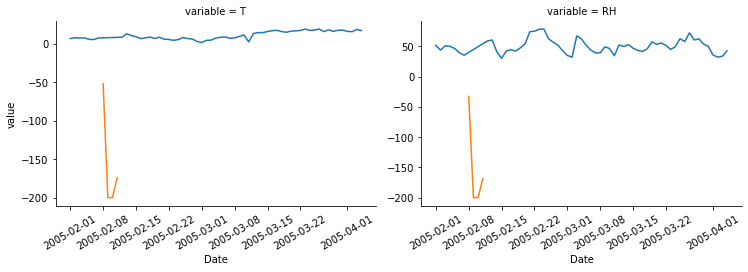

In [219]:
test_df['Drift'] = test_df['T'] < 0 # Initialise a Drift Variable
g = sns.FacetGrid(
        pd.melt(test_df, id_vars=['Date', 'Drift'], value_vars=['T','RH']).drop_duplicates(), 
        col="variable",
        hue='Drift',
        col_wrap= 2,
        sharey=False,
        height=3.5,
        aspect=1.5
    )
g.map(sns.lineplot, "Date", "value", estimator = None)
g.set_xticklabels(rotation=30)
plt.show()

In [220]:
test_df.loc[test_df[test_df['Drift']].index,['T','RH']] = np.nan
test_df_imp = test_df.fillna(method='ffill')
test_df_imp[test_df_imp['Drift']]

,id,Date,T,RH,Gas,Drift
7,7,2005-02-08,7.307986,35.396875,CO,True
8,8,2005-02-09,7.307986,35.396875,CO,True
9,9,2005-02-10,7.307986,35.396875,CO,True
10,10,2005-02-11,7.307986,35.396875,CO,True
70,70,2005-02-08,7.307986,35.396875,NMHC,True
71,71,2005-02-09,7.307986,35.396875,NMHC,True
72,72,2005-02-10,7.307986,35.396875,NMHC,True
73,73,2005-02-11,7.307986,35.396875,NMHC,True
133,133,2005-02-08,7.307986,35.396875,NOx,True
134,134,2005-02-09,7.307986,35.396875,NOx,True


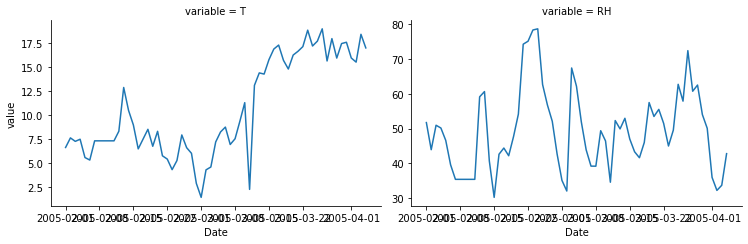

In [221]:
g = sns.FacetGrid(
        pd.melt(test_df_imp, id_vars=['Date', 'Drift'], value_vars=['T','RH']).drop_duplicates(), 
        col="variable",
        col_wrap= 2,
        sharey=False,
        height=3.5,
        aspect=1.5
    )
g.map(sns.lineplot, "Date", "value", estimator = None)

## ARIMA Forecast : Test Set

In [223]:
train_final = df_time_impute[target_vars]
train_final_x = df_time_impute[['T','RH']]
test_final_x = test_df_imp[['T','RH']].iloc[:63]
# orders_final = [((2,1,2),(1,1,1,7)), ((4,1,2),(1,1,1,7)), ((4,1,2),(1,1,1,7)), ((7,0,8),None)]
# orders_final = [((2,1,4),None), ((5,1,8),None), ((7,1,7),None), ((7,0,8),None)]
orders_final = [((4,1,1),(1,1,3,21)), ((4,1,3),(3,1,1,7)), ((2,1,4),(1,1,2,21)), ((7,0,9),None)]

submissions = dict()

for idx, (order, seasonal_order) in enumerate(orders_final):
    warnings.filterwarnings("ignore")
    mod = SARIMAX(train_final.iloc[:,idx],exog = train_final_x, order = order, seasonal_order = seasonal_order)
    res = mod.fit()
    submissions[target_vars[idx]] = res.forecast(63, exog = test_final_x).values

test_df['Value'] = pd.DataFrame(submissions).T.values.reshape((-1,1))
test_df.head()

,id,Date,T,RH,Gas,Drift,Value
0,0,2005-02-01,6.616667,51.734375,CO,False,1193.465980
1,1,2005-02-02,7.613194,43.930903,CO,False,1113.271199
2,2,2005-02-03,7.252083,50.966667,CO,False,1177.562453
3,3,2005-02-04,7.473611,50.166319,CO,False,1134.767352
4,4,2005-02-05,5.571875,46.604167,CO,False,1057.182321


## Padding -200 Null Values

In [224]:
test_df.Value[test_df.id.isin([8,9,71,72,134,135,197,198])] = -200
test_df[test_df.Value == -200]

,id,Date,T,RH,Gas,Drift,Value
8,8,2005-02-09,NaN,NaN,CO,True,-200.0
9,9,2005-02-10,NaN,NaN,CO,True,-200.0
71,71,2005-02-09,NaN,NaN,NMHC,True,-200.0
72,72,2005-02-10,NaN,NaN,NMHC,True,-200.0
134,134,2005-02-09,NaN,NaN,NOx,True,-200.0
135,135,2005-02-10,NaN,NaN,NOx,True,-200.0
197,197,2005-02-09,NaN,NaN,O3,True,-200.0
198,198,2005-02-10,NaN,NaN,O3,True,-200.0


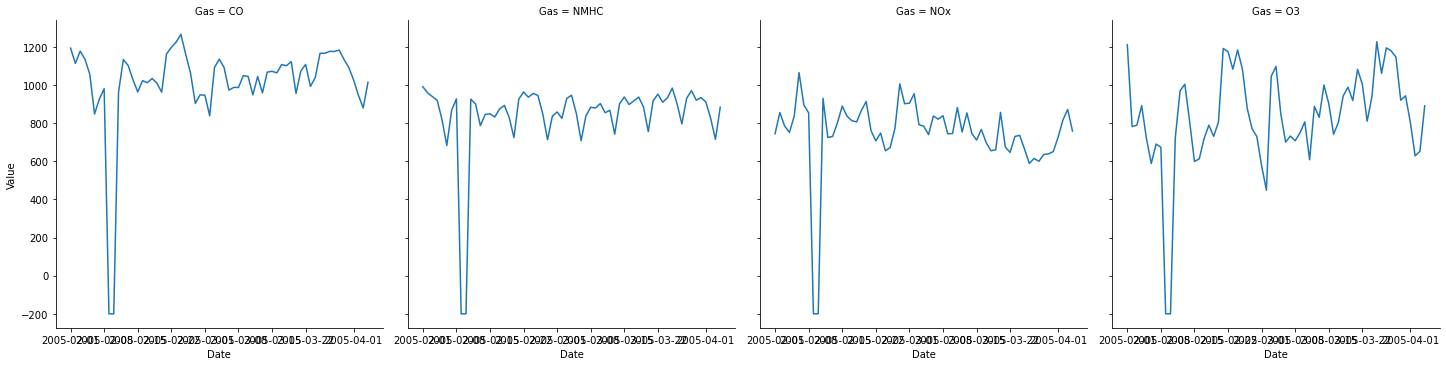

In [225]:
sns.relplot(kind='line', x='Date', y='Value', col='Gas',data = test_df)

## Outputing Submission csv

In [226]:
test_df[['id', 'Value']].to_csv("Data/Submission/mix_simple_tune2.csv",index=False)

## Kaggle Submission

In [227]:
!kaggle competitions submit -c st1511-aiml-timeseries -f Data/Submission/mix_simple_tune2.csv -m "Sarimxa[T,RH],((4,1,1),(1,1,3,21)), ((4,1,3),(3,1,1,7)), ((2,1,4),(1,1,2,21)), ((7,0,9),None),Pad-200"


  0%|          | 0.00/5.51k [00:00<?, ?B/s]
100%|██████████| 5.51k/5.51k [00:07<00:00, 719B/s]


Successfully submitted to ST1511-AIML-Time Series


## Personal Learning Reflection
This is the first time that I embarked on solving a time-series related project and given the limited time I have, the best I can do is just to **Interpret the ACF and PACF Plots**, **Tune a Simple ARIMA, ARIMAX and SARIMAX model** and implement some cross-validation techniques like **Expanding Window selection**. I hope that I build a more robust model by utilising **LSTM Networks** (to maybe to predict some stock price next time).

Written By : Wong Zhao Wu

Last Modified : 11 August 2021

![Stonk Meme](https://i.kym-cdn.com/entries/icons/original/000/029/959/Screen_Shot_2019-06-05_at_1.26.32_PM.jpg)

Source : [Stonk Meme](https://knowyourmeme.com/memes/stonks)